In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [26]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [27]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [28]:
df = pd.read_csv('/content/fashion.csv') # use process.py file to create this dataset
df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,label
0,0,0,0,0,0,0,1,1,1,0,...,0,15,3,0,20,0,0,0,0,2
1,0,0,0,0,0,0,1,0,0,15,...,167,134,0,16,180,160,16,0,0,2
2,0,0,0,0,0,0,0,0,1,0,...,0,0,105,99,80,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,60,...,0,0,0,53,108,95,21,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,119,148,83,0,0,0,0,2


In [29]:
df['label'].unique()

array([2, 6, 0, 1, 5, 9, 4, 7, 3, 8])

In [30]:
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,0,0,0,0,0,0,0,0,0,0,...,200,204,206,46,0,5,0,0,0,0
2,0,0,0,0,0,0,0,0,0,93,...,62,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
8,0,0,0,0,0,0,1,4,0,0,...,4,0,7,158,150,68,0,0,0,4
9,0,0,0,0,0,0,0,0,0,0,...,186,212,73,0,0,0,0,0,0,8


In [31]:
df.shape

(60000, 785)

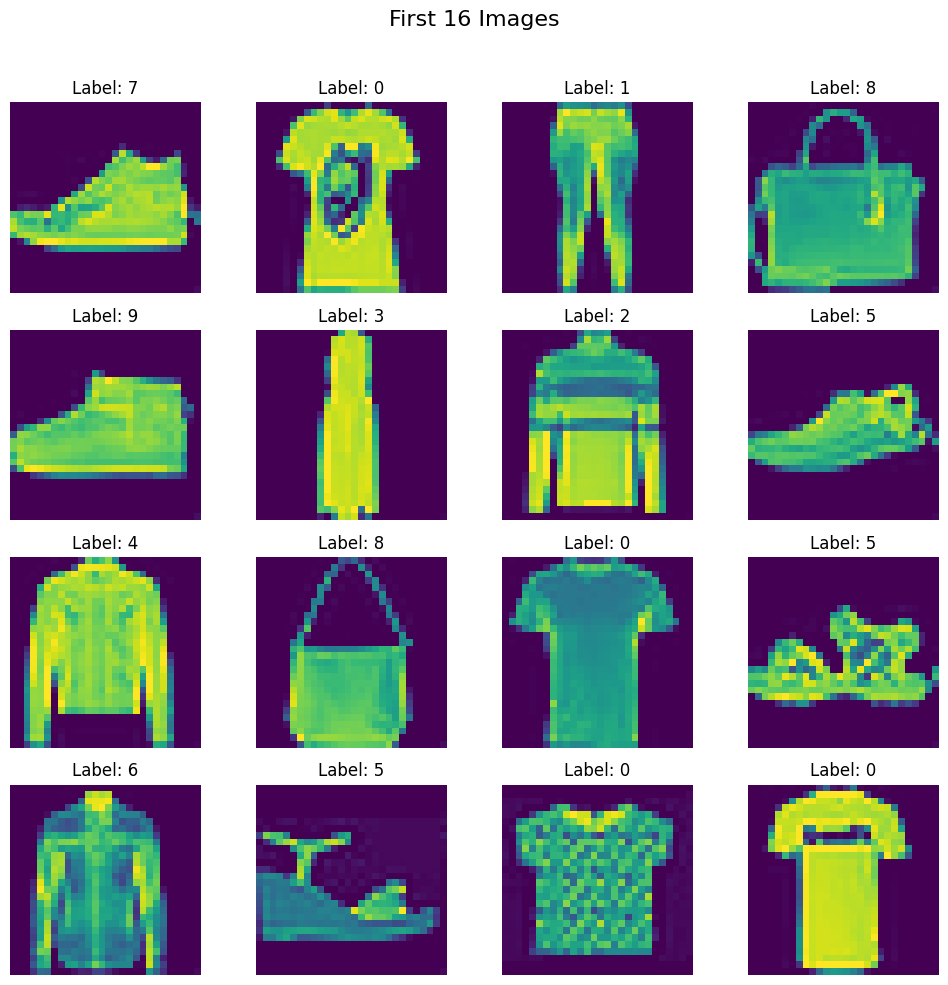

In [32]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, -1]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [33]:
# train test split

X = df.iloc[:,:-1].values
y = df.iloc[:, -1].values

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
X_train = X_train/255.0
X_test = X_test/255.0

In [37]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):

    # Convert to PyTorch tensors
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)
    print(self.labels.dtype)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [39]:
train_dataset = CustomDataset(X_train, y_train)

torch.int64


In [40]:
test_dataset = CustomDataset(X_test, y_test)

torch.int64


In [41]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [42]:
len(train_loader)

1500

In [43]:
class MyNN(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

In [44]:
learning_rate = 0.01
epochs = 100

In [45]:
model = MyNN(X_train.shape[1])

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

In [46]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.619302522033453
Epoch: 2 , Loss: 0.4902064956128597
Epoch: 3 , Loss: 0.453302829404672
Epoch: 4 , Loss: 0.4291389344930649
Epoch: 5 , Loss: 0.41494396346310775
Epoch: 6 , Loss: 0.397141409193476
Epoch: 7 , Loss: 0.38872734022637206
Epoch: 8 , Loss: 0.37821760402619836
Epoch: 9 , Loss: 0.37196000542740026
Epoch: 10 , Loss: 0.3671195301065842
Epoch: 11 , Loss: 0.35720075920720895
Epoch: 12 , Loss: 0.3534082879250248
Epoch: 13 , Loss: 0.3477000328252713
Epoch: 14 , Loss: 0.3454568723787864
Epoch: 15 , Loss: 0.34293173264463744
Epoch: 16 , Loss: 0.3355253511170546
Epoch: 17 , Loss: 0.3299917600999276
Epoch: 18 , Loss: 0.32812913117806114
Epoch: 19 , Loss: 0.32637490293880306
Epoch: 20 , Loss: 0.3280206909577052
Epoch: 21 , Loss: 0.3200226560086012
Epoch: 22 , Loss: 0.32058862898747126
Epoch: 23 , Loss: 0.31834301657726366
Epoch: 24 , Loss: 0.3152517715841532
Epoch: 25 , Loss: 0.31039391562342644
Epoch: 26 , Loss: 0.309926816838483
Epoch: 27 , Loss: 0.3105995392600695
Epo

In [22]:
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [23]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.8915833333333333


In [24]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.94125
